# Usage Example: Analysis csv-file

In [1]:
import numpy as np
import json
import matplotlib.pyplot as plt
import pandas as pd
import quickpbsa as pbsa

%matplotlib notebook

/usr/lib/python3.9/site-packages/tifffile/tifffile.py:3394: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if key is 0:  # noqa: comparison to literal


## Input file

In [2]:
tracefile = './Data/ExampleStack_difference.csv'
pd.read_csv(tracefile, header=1).loc[:5, :]

,id,x [nm],y [nm],sigma [nm],intensity [photon],center_pix,0,1,2,3,...,990,991,992,993,994,995,996,997,998,999
0,1,1323.97331,10382.87677,137.91881,1390.67689,6918,2108.054147,2057.048387,2130.452765,1888.403226,...,9.100230,10.105991,15.228111,19.173963,17.168203,7.199309,16.447005,15.807604,10.099078,15.387097
1,2,2973.21481,7682.14994,138.17243,694.57592,5135,976.176068,870.417094,814.810826,856.723077,...,-10.324786,-2.817094,-5.583476,-9.177208,-1.682621,-0.427920,5.531624,0.610826,-3.955556,1.502564
2,3,3123.68611,17095.39939,138.20926,1257.29196,11408,1868.709016,1885.335480,1773.676815,1892.166862,...,-4.848946,-2.997073,1.855386,-6.028103,-1.468384,-5.820843,1.923888,-0.889930,-0.092506,-12.531030
3,4,3074.09828,22629.48721,134.92371,1555.16189,15248,2285.798491,2220.134698,2240.531250,1943.405172,...,12.346444,10.218211,12.751616,8.892780,10.561961,7.872306,16.672953,18.081358,8.659483,5.337284
4,5,4014.61271,10108.24932,134.19890,1186.57157,6805,1818.690716,1789.437135,1822.765517,1850.262599,...,-0.469496,-2.966578,0.933687,1.658355,1.883820,-2.405836,2.565517,1.096552,2.436605,-0.356499
5,6,5736.30663,20352.34091,136.62630,1599.59023,13726,2314.493534,2388.341056,2336.439655,2337.733297,...,5.568427,5.265625,7.882004,9.359375,3.905711,7.251078,3.837823,5.430496,5.290948,5.197198


In the input file each row corresponds to one trace. It also contains a number of columns from the localization file that was used for trace extraction, but this is not neccessary for the analysis to work.

## Analysis

The entire analysis of the file can be accomplished with a single call to the function `pbsa_file`:

```python
KVthreshold = 100
maxiter = 100
pbsa.pbsa_file(file, KVthreshold, maxiter)
```

but this notebook uses lower level functions to explain the steps of the analysis one by one

### Preliminary Step Detection

First is the preliminary step detection, which produces 2 output files along with a log file.

In [3]:
KVthreshold = 100 # KV threshold (1/3 to 1/2 of typical last step)
KV_maxiter = 100   # Maximum KV iterations (much higher than expected number of steps)
kvout, kv_outfile, kv_jsonfile = pbsa.steps_preliminary.kv_file(tracefile, KVthreshold, KV_maxiter)
kvout.iloc[25:30,:14]

,id,x [nm],y [nm],sigma [nm],intensity [photon],center_pix,crop_index,kv_time [s],kv_iter,laststep,sdev_laststep,bg,sdev_bg,flag
25,6,5736.30663,20352.34091,136.6263,1599.59023,13726,0,0.21745,28,276.494324,13.588891,6.73402,20.608286,1
26,6,5736.30663,20352.34091,136.6263,1599.59023,13726,0,0.21745,28,276.494324,13.588891,6.73402,20.608286,1
27,6,5736.30663,20352.34091,136.6263,1599.59023,13726,0,0.21745,28,276.494324,13.588891,6.73402,20.608286,1
28,6,5736.30663,20352.34091,136.6263,1599.59023,13726,0,0.21745,28,276.494324,13.588891,6.73402,20.608286,1
29,6,5736.30663,20352.34091,136.6263,1599.59023,13726,0,0.21745,28,276.494324,13.588891,6.73402,20.608286,1


The output file 'ExampleStack_difference_kvout.csv' contains a few additional parameters:

- **crop_index** is the frame at which the traces were automatically cropped for analysis purposes, which is enabled by default
- **kv_time [s]** is the runtime of the preliminary step detection for each trace
- **kv_iter** is the number of iterations needed for preliminary step detection. If this often reaches maxiter, consider increasing maxiter.
- **laststep** and **sdev_laststep** are the intensity and standard deviation between the last 2 steps.
- **bg** and **sdev_bg** are the intensity and standard deviation after the last step

At this stage the flags in the file are 1 if steps are found and -1 if no steps are found. The output file then contains 5 rows for each input trace, which are plotted below. They are:

- the original trace
- the means between the steps
- the variance between the steps
- the fluorophores calculated with a simple ruler method, i.e. multiples of the last step signal
- the fluorophores if each preliminary step is considered to be a bleaching / turn-on event with occupancy 1 

<IPython.core.display.Javascript object>


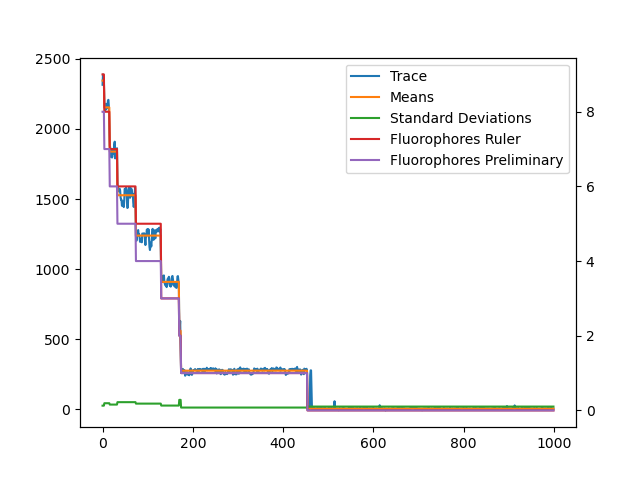

In [4]:
plt.figure()
plt.plot(np.array(kvout.iloc[25, 15:]), label='Trace')
plt.plot(np.array(kvout.iloc[26, 15:]), label='Means')
variances = np.array(kvout.iloc[27, 15:])
plt.plot(np.sqrt(variances.astype(float)), label='Standard Deviations')
ax1 = plt.gca()
ax2 = plt.gca().twinx()
ax2.plot(np.array(kvout.iloc[28, 15:]), label='Fluorophores Ruler', color='C3')
ax2.plot(np.array(kvout.iloc[29, 15:]), label='Fluorophores Preliminary', color='C4')
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2)
plt.show()

The .json file which is also exported contains similar information in a more complex format and is needed for the step refinement. If also helps to restart the analysis where it last stopped if something goes wrong.

### Filter Traces

Next Traces are excluded from further analysis by a number of criteria:

| flag | Meaning |
| :--  | :------
| -1   | No steps found in preliminary step detection
| -2   | Background intensity out of bounds
| -3   | Single fluorophore intensity out of bounds
| -4   | Trace goes into negative values
| -5   | Fluorophore number becomes negative
| -6   | interval between final two steps is too short

[ 0  0  0  0  0  0  0  0 -3 -3  0  0  0  0  0  0 -6]


<IPython.core.display.Javascript object>


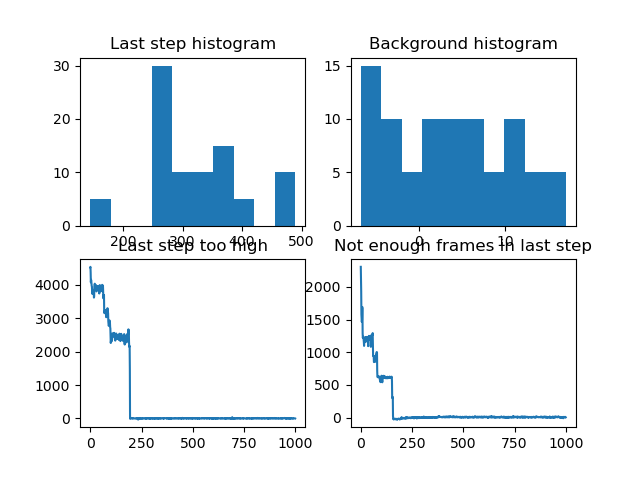

In [5]:
kvjson = json.load(open(kv_jsonfile))
kvresult = pd.read_csv(kv_outfile, header=1)
traces = np.array(kvresult.loc[kvresult['type']=='trace', '0':])

flags, avg_laststep = pbsa.steps_refinement.generate_flags(kvjson, KVthreshold)
print(flags)

fig,ax=plt.subplots(2,2)
ax[0][0].hist(np.array(kvout['laststep'])-np.array(kvout['bg']))
ax[0][0].set_title('Last step histogram')
ax[0][1].hist(np.array(kvout['bg']))
ax[0][1].set_title('Background histogram')
ax[1][0].plot(traces[8,:1000])
ax[1][0].set_title('Last step too high')
ax[1][1].plot(traces[16,:1000])
ax[1][1].set_title('Not enough frames in last step')
plt.show()

### Refine PBSA Result

The result refinement is performed on the remaining traces with a call to improve_steps_file, with all parameters on default values.

In [6]:
result = pbsa.steps_refinement.improve_steps_file(kv_outfile, kv_jsonfile)
result.iloc[35:42, :16]

/home/johan/Software/Libraries/quickpbsa/quickpbsa/steps_refinement/refinement_lowlevel.py:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sic = sum(nphi*np.log(varphi) + np.array(list(map(sum, (np.split(data, jpos) - i*mf - mb)**2)))/varphi)
/home/johan/Software/Libraries/quickpbsa/quickpbsa/steps_refinement/refinement_lowlevel.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  diffar = np.tile(np.array(list(map(sum, (np.split(data, jpos) - i_in*mf - mb)**2))), [sz - jpos[1], 1])
/home/johan/Software/Libraries/quickpbsa/quickpbsa/steps_refineme

,id,x [nm],y [nm],sigma [nm],intensity [photon],center_pix,crop_index,kv_time [s],kv_iter,laststep,sdev_laststep,bg,sdev_bg,flag,step2_time [s],sic_final
35,6,5736.30663,20352.34091,136.6263,1599.59023,13726,0,0.21745,28,276.494324,13.588891,6.73402,20.608286,1,0,8491.220351
36,6,5736.30663,20352.34091,136.6263,1599.59023,13726,0,0.21745,28,276.494324,13.588891,6.73402,20.608286,1,0,8491.220351
37,6,5736.30663,20352.34091,136.6263,1599.59023,13726,0,0.21745,28,276.494324,13.588891,6.73402,20.608286,1,0,8491.220351
38,6,5736.30663,20352.34091,136.6263,1599.59023,13726,0,0.21745,28,276.494324,13.588891,6.73402,20.608286,1,0,8491.220351
39,6,5736.30663,20352.34091,136.6263,1599.59023,13726,0,0.21745,28,276.494324,13.588891,6.73402,20.608286,1,0,8491.220351
40,6,5736.30663,20352.34091,136.6263,1599.59023,13726,0,0.21745,28,276.494324,13.588891,6.73402,20.608286,1,0,8491.220351
41,6,5736.30663,20352.34091,136.6263,1599.59023,13726,0,0.21745,28,276.494324,13.588891,6.73402,20.608286,1,0,8491.220351


## Output



<IPython.core.display.Javascript object>


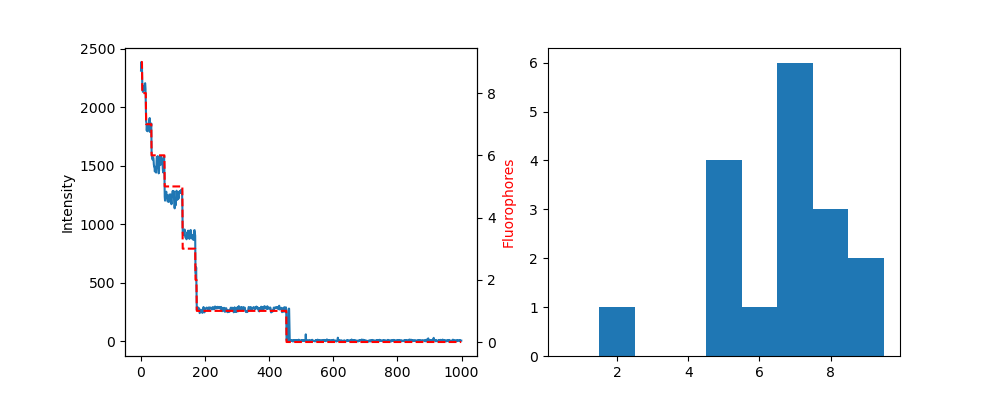

In [7]:
result = pd.read_csv('./Data/ExampleStack_difference_result.csv', header=1)
# Filter flagged traces
result = result.loc[result['flag']==1,:]

traces = np.array(result.loc[result['type']=='trace', '0':])
fluors_full = np.array(result.loc[result['type']=='fluors_full','0':])

fig,ax=plt.subplots(1,2)
ax[0].plot(traces[5,:1000])
ax[0].set_ylabel('Intensity')
ax1=ax[0].twinx()
ax1.plot(fluors_full[5,:1000], 'r--')
ax1.set_ylabel('Fluorophores', color='r')
ax[1].hist(fluors_full[:,0], bins=np.arange(10)+0.5)
fig.set_size_inches([10,4])
plt.show()